# Effects of Bad Family Relations on Student Academics
### Introduction

Our topic based on the dataset we chose is to find a relationship between a student’s academics and the relations within their family. 

Question: Does bad relations within students’ families affect their studies?

The data set we chose is the Student Performance Data Set, which displays student achievement in secondary education of two Portuguese schools. The data contains every kind of information of the student. It ranges from the students’ age to their alcohol consumption, to information about their parents.

### Preliminary exploratory data analysis
#### Libraries

In [189]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1234)

#### Reading the data set

In [3]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", temp)
student_data <- read_csv2(unz(temp, "student-mat.csv"))
unlink(temp)
student_data

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


#### Cleaning the data

In [184]:
student_tidy_data <- student_data %>%
    select(c(studytime, failures, absences, G1, G2, G3)) %>%
    mutate_at(c("studytime", "failures"), as.factor) %>%
    mutate_if(is.numeric, function(x) (x - mean(x))/sd(x)) %>%
    mutate(failures = as.numeric(failures)-1)
student_tidy_data

studytime,failures,absences,G1,G2,G3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0,0.03637833,-1.780209,-1.2532017,-0.96371171
2,0,-0.21352497,-1.780209,-1.5190528,-0.96371171
2,3,0.53618492,-1.177653,-0.7214996,-0.09062427
⋮,⋮,⋮,⋮,⋮,⋮
1,3,-0.33847662,-0.27381966,-0.7214996,-0.74543985
1,0,-0.71333156,0.02745824,0.3419047,-0.09062427
1,0,-0.08857332,-0.87637546,-0.4556485,-0.30889613


#### Data summary

In [190]:
student_split <- initial_split(student_tidy_data, prop = 0.8)
student_train <- training(student_split)
student_test <- testing(student_split)
summary(student_train)

 studytime    failures         absences              G1          
 1: 83     Min.   :0.0000   Min.   :-0.71333   Min.   :-2.38277  
 2:158     1st Qu.:0.0000   1st Qu.:-0.71333   1st Qu.:-0.87638  
 3: 54     Median :0.0000   Median :-0.21352   Median : 0.02746  
 4: 22     Mean   :0.3375   Mean   :-0.01053   Mean   : 0.00750  
           3rd Qu.:0.0000   3rd Qu.: 0.28628   3rd Qu.: 0.63001  
           Max.   :3.0000   Max.   : 8.65804   Max.   : 2.43768  
       G2                 G3          
 Min.   :-2.84831   Min.   :-2.27334  
 1st Qu.:-0.45565   1st Qu.:-0.30890  
 Median : 0.07605   Median : 0.12765  
 Mean   : 0.02657   Mean   : 0.02987  
 3rd Qu.: 0.60776   3rd Qu.: 0.78246  
 Max.   : 2.20286   Max.   : 2.09209  

#### Tuning Model

In [195]:
rec <- recipe(G3 ~ G1 + G2 + failures + absences, student_train)

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

fit <- workflow() %>%
    add_recipe(rec) %>%
    add_model(spec)    

student_vfold <- student_train %>%
    vfold_cv(v = 5, strata = G3)

gridvals <- tibble(neighbors = seq(1, 10))

fit %<>% tune_grid(resamples = student_vfold, grid = gridvals) %>%
    collect_metrics()
fit %>% filter(.metric == "rmse") %>% slice(3)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,0.4441415,5,0.05196178,Model03


#### Finding Min

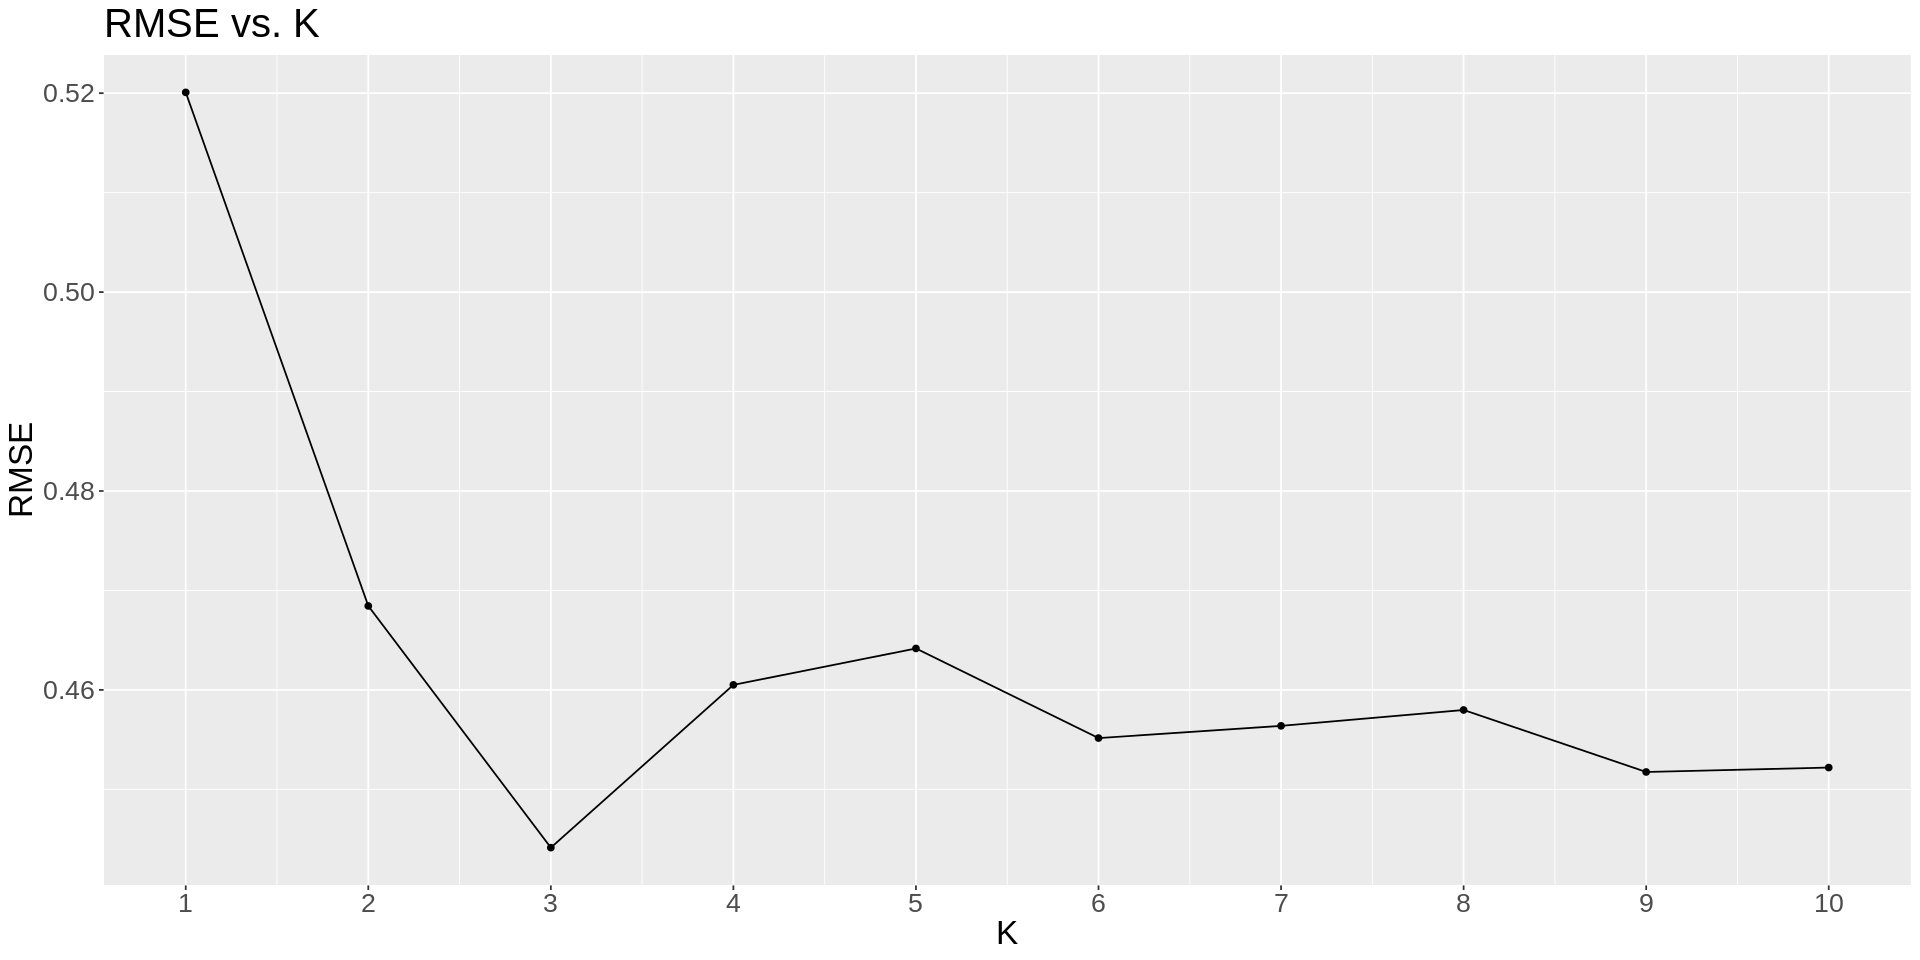

In [199]:
options(repr.plot.width = 16, repr.plot.height = 8)
accuracy_k_plot <- fit %>%
    filter(.metric == "rmse") %>%
    arrange(desc(mean)) %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "RMSE vs. K",
             x = "K",
             y = "RMSE") +
        theme(text = element_text(size = 20)) +
        scale_x_continuous(breaks = 1:10)
accuracy_k_plot

#### Final Model

In [197]:
student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
    set_engine("kknn") %>%
    set_mode("regression")

student_predictions <- workflow() %>%
    add_recipe(rec) %>%
    add_model(student_spec) %>%
    fit(student_train) %>%
    predict(student_test) %>%
    bind_cols(student_test)
student_predictions %>%
    metrics(truth = G3, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.4195794
rsq,standard,0.8641673
mae,standard,0.2630456


### Methods

For this data analysis, we chose to only look at the final grade (G3). We will conduct this process using the variables/columns; failures, higher, famrel, and famsup. We chose these variables because it is the relationships within the families that we are observing, therefore famsup is used. The number of class failures is also looked at as we relate those with the other variables. Lastly, we would also like to take into account how many students want to take higher education as bad relations within the family could influence these results.
A scatterplot would be used to visualize the results because they detect whether a relationship or correlation between two variables exist, which is what we are trying to visualize with our data. We will be performing a classification, therefore a scatterplot would display this data the best.

### Expected outcomes and significance

#### What do you expect to find?
We think this model will give a more clear insight to how bad relations can affect students' education by classifying  attributes like final grade, and even how likely it is that they will fail. We expect that students with such conditions are more likely to opt to pursue higher education but are also more likely to fail.

#### What impact could such findings have?
We think such insight will help schools as well as parents be more prepared in helping the students succeed and get a better education; by providing students extra classes, ways to open up and deal with the mental issues and even give them more opportunities in their interest fields to divert their minds from the issues at their homes.

#### What future questions could this lead to?
From this data analysis, we would find out how relationships within the student’s families affect their studies, but what about other factors within a students’ life? Questions such as;
How does students’ health relate to their academic education?
Could a  student’s romantic relationship affect their studies?
How does a student’s use of their freetime contribute to their studies?


Ethan Thoma, Divyansh Jain, Qiying Chen